# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on simple tokenization (11 tokens)

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-simple'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom = meta['stoi'], meta['itos'], meta['stom']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
str_to_moves = lambda s: ''.join([stom[c] for c in s])
ids_to_moves = lambda l: ''.join([stom[itos[i]] for i in l])

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59243/59665 (99.29%)
Game result predicted (validation data): 1671/2000 (83.55%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 495520/498639 (99.37%)
Game result predicted (training data): 15910/18000 (88.39%)


## Probing

### Get output from hidden layers of the model

In [11]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [12]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [13]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [14]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [15]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [16]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [17]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [18]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [19]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [20]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.4481
Epoch   1: 0.9375
Epoch   2: 0.7955
Epoch   3: 0.7223
Epoch   4: 0.6734
Epoch   5: 0.6375
Epoch   6: 0.6101
Epoch   7: 0.5884
Epoch   8: 0.5710
Epoch   9: 0.5565
Epoch  10: 0.5446
Epoch  11: 0.5345
Epoch  12: 0.5256
Epoch  13: 0.5179
Epoch  14: 0.5113
Epoch  15: 0.5051
Epoch  16: 0.4998
Epoch  17: 0.4948
Epoch  18: 0.4905
Epoch  19: 0.4866
Epoch  20: 0.4827
Epoch  21: 0.4792
Epoch  22: 0.4759
Epoch  23: 0.4731
Epoch  24: 0.4703
Epoch  25: 0.4676
Epoch  26: 0.4654
Epoch  27: 0.4630
Epoch  28: 0.4609
Epoch  29: 0.4587
Epoch  30: 0.4567
Epoch  31: 0.4551
Epoch  32: 0.4533
Epoch  33: 0.4516
Epoch  34: 0.4500
Epoch  35: 0.4484
Epoch  36: 0.4469
Epoch  37: 0.4454
Epoch  38: 0.4442
Epoch  39: 0.4428
Epoch  40: 0.4417
Epoch  41: 0.4403
Epoch  42: 0.4394
Epoch  43: 0.4381
Epoch  44: 0.4369
Epoch  45: 0.4360
Epoch  46: 0.4349
Epoch  47: 0.4339
Epoch  48: 0.4331
Epoch  49: 0.4322
Epoch  50: 0.4312
Epoch  51: 0.4304
Epoch  52: 0.4296
Epoch  53: 0.4287
Epoch  54: 0.4277
Epoch  55:

Predict number of pieces in each column

In [21]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 2.5225
Epoch   1: 1.7545
Epoch   2: 1.4637
Epoch   3: 1.3002
Epoch   4: 1.1916
Epoch   5: 1.1120
Epoch   6: 1.0495
Epoch   7: 0.9981
Epoch   8: 0.9558
Epoch   9: 0.9193
Epoch  10: 0.8878
Epoch  11: 0.8604
Epoch  12: 0.8360
Epoch  13: 0.8144
Epoch  14: 0.7948
Epoch  15: 0.7769
Epoch  16: 0.7607
Epoch  17: 0.7458
Epoch  18: 0.7316
Epoch  19: 0.7190
Epoch  20: 0.7069
Epoch  21: 0.6958
Epoch  22: 0.6852
Epoch  23: 0.6753
Epoch  24: 0.6660
Epoch  25: 0.6576
Epoch  26: 0.6489
Epoch  27: 0.6413
Epoch  28: 0.6334
Epoch  29: 0.6261
Epoch  30: 0.6193
Epoch  31: 0.6126
Epoch  32: 0.6063
Epoch  33: 0.6004
Epoch  34: 0.5948
Epoch  35: 0.5891
Epoch  36: 0.5839
Epoch  37: 0.5787
Epoch  38: 0.5735
Epoch  39: 0.5689
Epoch  40: 0.5639
Epoch  41: 0.5594
Epoch  42: 0.5550
Epoch  43: 0.5507
Epoch  44: 0.5466
Epoch  45: 0.5425
Epoch  46: 0.5386
Epoch  47: 0.5353
Epoch  48: 0.5313
Epoch  49: 0.5276
Epoch  50: 0.5239
Epoch  51: 0.5212
Epoch  52: 0.5176
Epoch  53: 0.5147
Epoch  54: 0.5112
Epoch  55:

Predict number of pieces in each row

In [22]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.5883
Epoch   1: 1.7744
Epoch   2: 1.4972
Epoch   3: 1.3552
Epoch   4: 1.2614
Epoch   5: 1.1924
Epoch   6: 1.1388
Epoch   7: 1.0963
Epoch   8: 1.0612
Epoch   9: 1.0310
Epoch  10: 1.0054
Epoch  11: 0.9833
Epoch  12: 0.9641
Epoch  13: 0.9474
Epoch  14: 0.9319
Epoch  15: 0.9175
Epoch  16: 0.9054
Epoch  17: 0.8937
Epoch  18: 0.8833
Epoch  19: 0.8732
Epoch  20: 0.8643
Epoch  21: 0.8561
Epoch  22: 0.8480
Epoch  23: 0.8402
Epoch  24: 0.8329
Epoch  25: 0.8268
Epoch  26: 0.8207
Epoch  27: 0.8150
Epoch  28: 0.8087
Epoch  29: 0.8039
Epoch  30: 0.7983
Epoch  31: 0.7932
Epoch  32: 0.7887
Epoch  33: 0.7838
Epoch  34: 0.7799
Epoch  35: 0.7755
Epoch  36: 0.7714
Epoch  37: 0.7677
Epoch  38: 0.7637
Epoch  39: 0.7599
Epoch  40: 0.7567
Epoch  41: 0.7532
Epoch  42: 0.7500
Epoch  43: 0.7465
Epoch  44: 0.7439
Epoch  45: 0.7412
Epoch  46: 0.7376
Epoch  47: 0.7352
Epoch  48: 0.7321
Epoch  49: 0.7296
Epoch  50: 0.7267
Epoch  51: 0.7241
Epoch  52: 0.7215
Epoch  53: 0.7196
Epoch  54: 0.7169
Epoch  55:

### Test linear probes

In [23]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [24]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [25]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.9011, 0.8932, 0.8978, 0.8995, 0.9251, 0.9521, 0.9759, 0.8499, 0.8351,
        0.8351, 0.8180, 0.8665, 0.9124, 0.9536, 0.7868, 0.7828, 0.7761, 0.7631,
        0.8062, 0.8623, 0.9098, 0.7686, 0.7531, 0.7547, 0.7536, 0.7894, 0.8245,
        0.8809, 0.7456, 0.7113, 0.6962, 0.6836, 0.7410, 0.7796, 0.8408, 0.7157,
        0.6852, 0.6791, 0.7169, 0.6984, 0.7202, 0.7774], device='cuda:0')

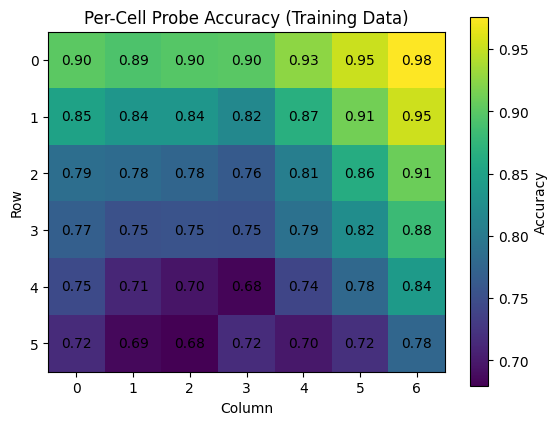

In [26]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [27]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.8890, 0.8885, 0.8853, 0.8890, 0.9049, 0.9413, 0.9730, 0.8309, 0.8097,
        0.8198, 0.7955, 0.8462, 0.8996, 0.9382, 0.7817, 0.7600, 0.7294, 0.7606,
        0.7933, 0.8293, 0.9001, 0.7426, 0.7294, 0.7215, 0.7336, 0.7585, 0.7970,
        0.8584, 0.7331, 0.6929, 0.6818, 0.6982, 0.7220, 0.7622, 0.8240, 0.6971,
        0.6691, 0.6797, 0.6887, 0.6982, 0.7135, 0.7548], device='cuda:0')

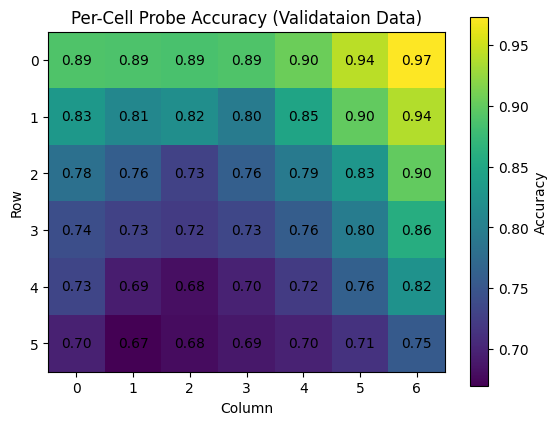

In [28]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [29]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.9533, 0.9347, 0.9415, 0.9598, 0.9289, 0.9212, 0.9215],
       device='cuda:0')

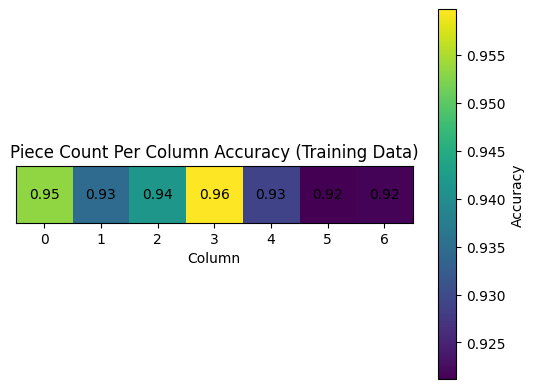

In [30]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [31]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.9355, 0.9144, 0.9128, 0.9271, 0.9107, 0.8959, 0.8890],
       device='cuda:0')

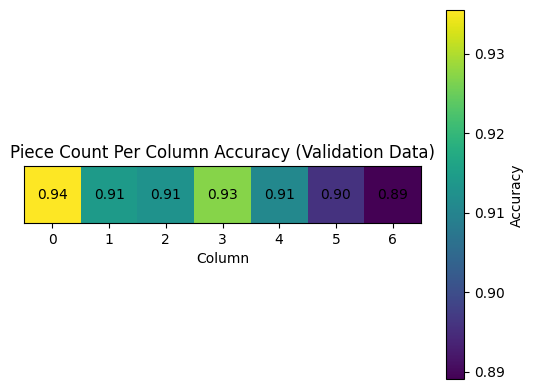

In [32]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [33]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.9074, 0.7818, 0.7715, 0.7852, 0.7822, 0.8225], device='cuda:0')

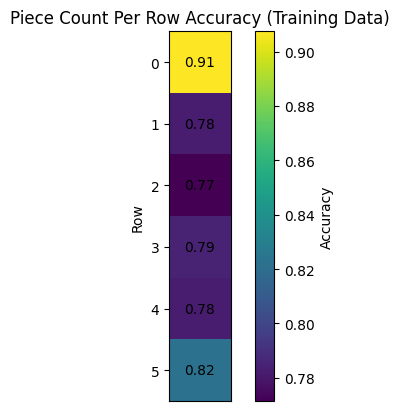

In [34]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [35]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.8795, 0.7421, 0.7410, 0.7521, 0.7611, 0.8034], device='cuda:0')

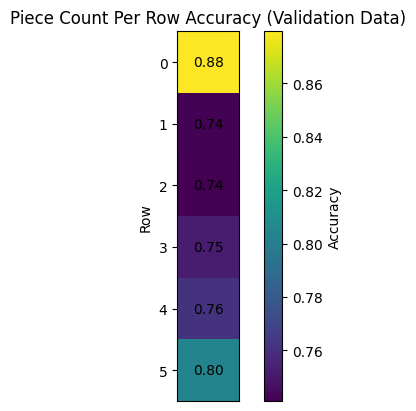

In [36]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)